#Importing Packages

In [ ]:
#Importing packages
import os
import random
import numpy as np
import seaborn as sns
from PIL import Image
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the dimensions of the input images
img_width, img_height = 224, 224
# Set the number of classes
num_classes = 2
# Set the path to the directory containing the images
data_path = "/content/drive/MyDrive/drishti-cg/Training/Images"
# Load the image data and labels
X = []
y = []
for label, folder_name in enumerate(["NORMAL", "GLAUCOMA"]):
    folder_path = os.path.join(data_path, folder_name)
    for filename in os.listdir(folder_path):
        image = Image.open(os.path.join(folder_path, filename))
        image = image.resize((img_width, img_height))
        image = np.array(image)
        X.append(image)
        y.append(label)

# Set a fixed random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

#Image PreProcessing

In [ ]:
# Convert the image data and labels to NumPy arrays
X = np.array(X)
y = np.array(y)
# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X.reshape(X.shape[0], -1), y)
# Reshape X back to 3D format
X = X.reshape(X.shape[0], img_width, img_height, 3)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize the image data to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
# Convert the labels to one-hot encoding
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

#Creating Models

In [ ]:
# Create the DenseNet121 model
base_dense_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
# Create the Xception model
base_xception_model = Xception(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
# Load the InceptionV3 model without the top classification layer
base_inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load VGG16 without top layers and freeze base
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile model
vgg_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    steps_per_epoch=math.ceil(len(X_train) / 32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5691 - loss: 0.7573 - val_accuracy: 0.7405 - val_loss: 0.4983
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step - accuracy: 0.6782 - loss: 0.5896 - val_accuracy: 0.8544 - val_loss: 0.4169
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.7398 - loss: 0.4912 - val_accuracy: 0.8608 - val_loss: 0.3541
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.8038 - loss: 0.4295 - val_accuracy: 0.8797 - val_loss: 0.3574
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 526ms/step - accuracy: 0.8560 - loss: 0.3856 - val_accuracy: 0.9367 - val_loss: 0.2928
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.8304 - loss: 0.3676 - val_accuracy: 0.9241 - val_loss: 0.2863
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.8663 - loss: 0.3423 - val_accuracy: 0.9114 - val_loss: 0.2638
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - accuracy: 0.8428 - loss: 0.3416 - val_accuracy: 0

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load ResNet50 without top layers and freeze base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze all ResNet layers

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    steps_per_epoch=math.ceil(len(X_train) / 32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load ResNet50 without top layers and freeze base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze all ResNet layers

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    steps_per_epoch=math.ceil(len(X_train) / 32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4653 - loss: 0.8512 - val_accuracy: 0.4620 - val_loss: 0.7110
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.4846 - loss: 0.7800 - val_accuracy: 0.5823 - val_loss: 0.6832
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step - accuracy: 0.5117 - loss: 0.7689 - val_accuracy: 0.4620 - val_loss: 0.6854
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 429ms/step - accuracy: 0.5139 - loss: 0.7752 - val_accuracy: 0.4620 - val_loss: 0.6796
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.5695 - loss: 0.7035 - val_accuracy: 0.5380 - val_loss: 0.6717
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.5082 - loss: 0.7238 - val_accuracy: 0.6519 - val_loss: 0.6623
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.5306 - loss: 0.6998 - val_accuracy: 0.4620 - val_loss: 0.6710
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/st

#Adding custom classification layers

In [ ]:
# Add custom classification layers on top of the base dense model
dense_model = Sequential()
dense_model.add(base_dense_model)
dense_model.add(Flatten())
dense_model.add(Dense(256, activation='relu'))
dense_model.add(Dense(num_classes, activation='softmax'))


In [ ]:
# Add custom classification layers on top of the base dense model
inception_model = Sequential()
inception_model.add(base_inception_model)
inception_model.add(Flatten())
inception_model.add(Dense(256, activation='relu'))
inception_model.add(Dense(num_classes, activation='softmax'))


In [ ]:
# Add custom classification layers on top of the Xception base model
xception_model = Sequential()
xception_model.add(base_xception_model)
xception_model.add(Flatten())
xception_model.add(Dense(256, activation='relu'))
xception_model.add(Dense(num_classes, activation='softmax'))


In [ ]:
# Create the LeNet-5 model
lenet_model = Sequential()
lenet_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(img_width, img_height, 3)))
lenet_model.add(AveragePooling2D(pool_size=(2, 2)))
lenet_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
lenet_model.add(AveragePooling2D(pool_size=(2, 2)))
lenet_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
lenet_model.add(AveragePooling2D(pool_size=(2, 2)))
lenet_model.add(Flatten())
lenet_model.add(Dense(120, activation='relu'))
lenet_model.add(Dense(84, activation='relu'))
lenet_model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Compiling the models

In [ ]:
# Compile the dense model
dense_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Compile the xception model
xception_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Compile the lenet model
lenet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Compile the model
inception_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Training the models

In [ ]:
# # Train the model
# xception_model.fit(
#     datagen.flow(X_train, y_train, batch_size=32, seed = seed),
#     steps_per_epoch=len(X_train) // 32,
#     epochs=10,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stopping]
# )

import math

xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=seed),
    steps_per_epoch=math.ceil(len(X_train) / 32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4906 - loss: 2.3169 - val_accuracy: 0.5506 - val_loss: 0.6929
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 532ms/step - accuracy: 0.5005 - loss: 0.6931 - val_accuracy: 0.4620 - val_loss: 0.6936
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - accuracy: 0.5336 - loss: 0.6928 - val_accuracy: 0.4620 - val_loss: 0.6939
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 539ms/step - accuracy: 0.5089 - loss: 0.6931 - val_accuracy: 0.4620 - val_loss: 0.6940


In [ ]:
# Train the GoogleNet model
inception_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed = seed),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.5715 - loss: 5.4667 - val_accuracy: 0.4620 - val_loss: 173.7852
Epoch 2/10
 1/19 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.8750 - loss: 0.4807

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8750 - loss: 0.4807 - val_accuracy: 0.4620 - val_loss: 202.4492
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.8405 - loss: 0.4223 - val_accuracy: 0.4620 - val_loss: 108.3394
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8438 - loss: 0.3324 - val_accuracy: 0.4620 - val_loss: 104.9325
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 482ms/step - accuracy: 0.9049 - loss: 0.2522 - val_accuracy: 0.4620 - val_loss: 4.6660
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9375 - loss: 0.1988 - val_accuracy: 0.4620 - val_loss: 3.9967
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 461ms/step - accuracy: 0.9176 - loss: 0.1831 - val_accuracy: 0.7089 - val_loss: 1.0539
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8438 - loss: 0.2461 - val_accuracy: 0.8228 - val_loss: 0.6100
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.9287 - loss: 0.1532 - val_accuracy: 0.6646 - va

In [ ]:
# Train the DenseNet model
dense_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed = seed),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 304s 8s/step - accuracy: 0.7191 - loss: 4.6077 - val_accuracy: 0.6203 - val_loss: 9.7632
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9062 - loss: 0.3050 - val_accuracy: 0.6139 - val_loss: 11.9214
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 472ms/step - accuracy: 0.8030 - loss: 0.8901 - val_accuracy: 0.6203 - val_loss: 223.5610
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7812 - loss: 0.4041 - val_accuracy: 0.6203 - val_loss: 317.0490


In [ ]:
# Fit the model with data augmentation
lenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32,seed = seed),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 684ms/step - accuracy: 0.5712 - loss: 0.7540 - val_accuracy: 0.7532 - val_loss: 0.5159
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7188 - loss: 0.4939 - val_accuracy: 0.7658 - val_loss: 0.5089
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - accuracy: 0.7786 - loss: 0.5170 - val_accuracy: 0.7785 - val_loss: 0.4562
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7500 - loss: 0.4457 - val_accuracy: 0.7532 - val_loss: 0.4663
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.7725 - loss: 0.4613 - val_accuracy: 0.8354 - val_loss: 0.4264
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.3800 - val_accuracy: 0.8354 - val_loss: 0.4218
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.8203 - loss: 0.4014 - val_accuracy: 0.7595 - val_loss: 0.4731
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 0.4730 - val_accuracy: 0.7658 

#Performance Evaluation Metrics

In [ ]:
# Evaluate Xception model
loss, accuracy = xception_model.evaluate(X_test, y_test)
print(f"Test Loss of Xception: {loss:.4f}")
print(f"Test Accuracy of Xception: {accuracy:.4f}")

# Evaluate DenseNet model
loss, accuracy = dense_model.evaluate(X_test, y_test)
print(f"Test Loss of DenseNet: {loss:.4f}")
print(f"Test Accuracy of DenseNet: {accuracy:.4f}")

# Evaluate InceptionV3 model
loss, accuracy = inception_model.evaluate(X_test, y_test)
print(f"Test Loss of InceptionV3: {loss:.4f}")
print(f"Test Accuracy of InceptionV3: {accuracy:.4f}")

# Evaluate LeNet model
loss, accuracy = lenet_model.evaluate(X_test, y_test)
print(f"Test Loss of LeNet: {loss:.4f}")
print(f"Test Accuracy of LeNet: {accuracy:.4f}")

# Evaluate VGG16 model
loss, accuracy = vgg_model.evaluate(X_test, y_test)
print(f"Test Loss of VGG16: {loss:.4f}")
print(f"Test Accuracy of VGG16: {accuracy:.4f}")

# Evaluate ResNet50 model
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print(f"Test Loss of ResNet50: {loss:.4f}")
print(f"Test Accuracy of ResNet50: {accuracy:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5503 - loss: 0.6928
Test Loss of Xception: 0.6929
Test Accuracy of Xception: 0.5506
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6078 - loss: 8.8272
Test Loss of DenseNet: 9.7632
Test Accuracy of DenseNet: 0.6203
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8385 - loss: 0.5860
Test Loss of InceptionV3: 0.6100
Test Accuracy of InceptionV3: 0.8228
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8709 - loss: 0.3884
Test Loss of LeNet: 0.4218
Test Accuracy of LeNet: 0.8354
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9287 - loss: 0.2227
Test Loss of VGG16: 0.2379
Test Accuracy of VGG16: 0.9241
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6401 - loss: 0.6429
Test Loss of ResNet50: 0.6365
Test Accuracy of ResNet50: 0.6456


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# 1. DenseNet
y_pred_dense = dense_model.predict(X_test)
y_pred_dense_classes = np.argmax(y_pred_dense, axis=1)
y_true_dense = np.argmax(y_test, axis=1)
precision_dense = precision_score(y_true_dense, y_pred_dense_classes, average='weighted')
recall_dense = recall_score(y_true_dense, y_pred_dense_classes, average='weighted')
f1_dense = f1_score(y_true_dense, y_pred_dense_classes, average='weighted')

# 2. InceptionV3
y_pred_inception = inception_model.predict(X_test)
y_pred_inception_classes = np.argmax(y_pred_inception, axis=1)
y_true_inception = np.argmax(y_test, axis=1)
precision_inception = precision_score(y_true_inception, y_pred_inception_classes, average='weighted')
recall_inception = recall_score(y_true_inception, y_pred_inception_classes, average='weighted')
f1_inception = f1_score(y_true_inception, y_pred_inception_classes, average='weighted')

# 3. Xception
y_pred_xception = xception_model.predict(X_test)
y_pred_xception_classes = np.argmax(y_pred_xception, axis=1)
y_true_xception = np.argmax(y_test, axis=1)
precision_xception = precision_score(y_true_xception, y_pred_xception_classes, average='weighted')
recall_xception = recall_score(y_true_xception, y_pred_xception_classes, average='weighted')
f1_xception = f1_score(y_true_xception, y_pred_xception_classes, average='weighted')

# 4. LeNet
y_pred_lenet = lenet_model.predict(X_test)
y_pred_lenet_classes = np.argmax(y_pred_lenet, axis=1)
y_true_lenet = np.argmax(y_test, axis=1)
precision_lenet = precision_score(y_true_lenet, y_pred_lenet_classes, average='weighted')
recall_lenet = recall_score(y_true_lenet, y_pred_lenet_classes, average='weighted')
f1_lenet = f1_score(y_true_lenet, y_pred_lenet_classes, average='weighted')

# 5. VGG16
y_pred_vgg = vgg_model.predict(X_test)
y_pred_vgg_classes = np.argmax(y_pred_vgg, axis=1)
y_true_vgg = np.argmax(y_test, axis=1)
precision_vgg = precision_score(y_true_vgg, y_pred_vgg_classes, average='weighted')
recall_vgg = recall_score(y_true_vgg, y_pred_vgg_classes, average='weighted')
f1_vgg = f1_score(y_true_vgg, y_pred_vgg_classes, average='weighted')

# 6. ResNet50
y_pred_resnet = resnet_model.predict(X_test)
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=1)
y_true_resnet = np.argmax(y_test, axis=1)
precision_resnet = precision_score(y_true_resnet, y_pred_resnet_classes, average='weighted')
recall_resnet = recall_score(y_true_resnet, y_pred_resnet_classes, average='weighted')
f1_resnet = f1_score(y_true_resnet, y_pred_resnet_classes, average='weighted')


5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 781ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [ ]:
# DenseNet
print(f"Precision of DenseNet: {precision_dense:.4f}")
print(f"Recall of DenseNet: {recall_dense:.4f}")
print(f"F1 Score of DenseNet: {f1_dense:.4f}")

# Xception
print(f"Precision of Xception: {precision_xception:.4f}")
print(f"Recall of Xception: {recall_xception:.4f}")
print(f"F1 Score of Xception: {f1_xception:.4f}")

# InceptionV3
print(f"Precision of InceptionV3: {precision_inception:.4f}")
print(f"Recall of InceptionV3: {recall_inception:.4f}")
print(f"F1 Score of InceptionV3: {f1_inception:.4f}")

# LeNet
print(f"Precision of LeNet: {precision_lenet:.4f}")
print(f"Recall of LeNet: {recall_lenet:.4f}")
print(f"F1 Score of LeNet: {f1_lenet:.4f}")

# VGG16
print(f"Precision of VGG16: {precision_vgg:.4f}")
print(f"Recall of VGG16: {recall_vgg:.4f}")
print(f"F1 Score of VGG16: {f1_vgg:.4f}")

# ResNet50
print(f"Precision of ResNet50: {precision_resnet:.4f}")
print(f"Recall of ResNet50: {recall_resnet:.4f}")
print(f"F1 Score of ResNet50: {f1_resnet:.4f}")


Precision of DenseNet: 0.6498
Recall of DenseNet: 0.6203
F1 Score of DenseNet: 0.5812
Precision of Xception: 0.7552
Recall of Xception: 0.5506
F1 Score of Xception: 0.4041
Precision of InceptionV3: 0.8297
Recall of InceptionV3: 0.8228
F1 Score of InceptionV3: 0.8229
Precision of LeNet: 0.8365
Recall of LeNet: 0.8354
F1 Score of LeNet: 0.8347
Precision of VGG16: 0.9279
Recall of VGG16: 0.9241
F1 Score of VGG16: 0.9236
Precision of ResNet50: 0.7863
Recall of ResNet50: 0.6456
F1 Score of ResNet50: 0.5792


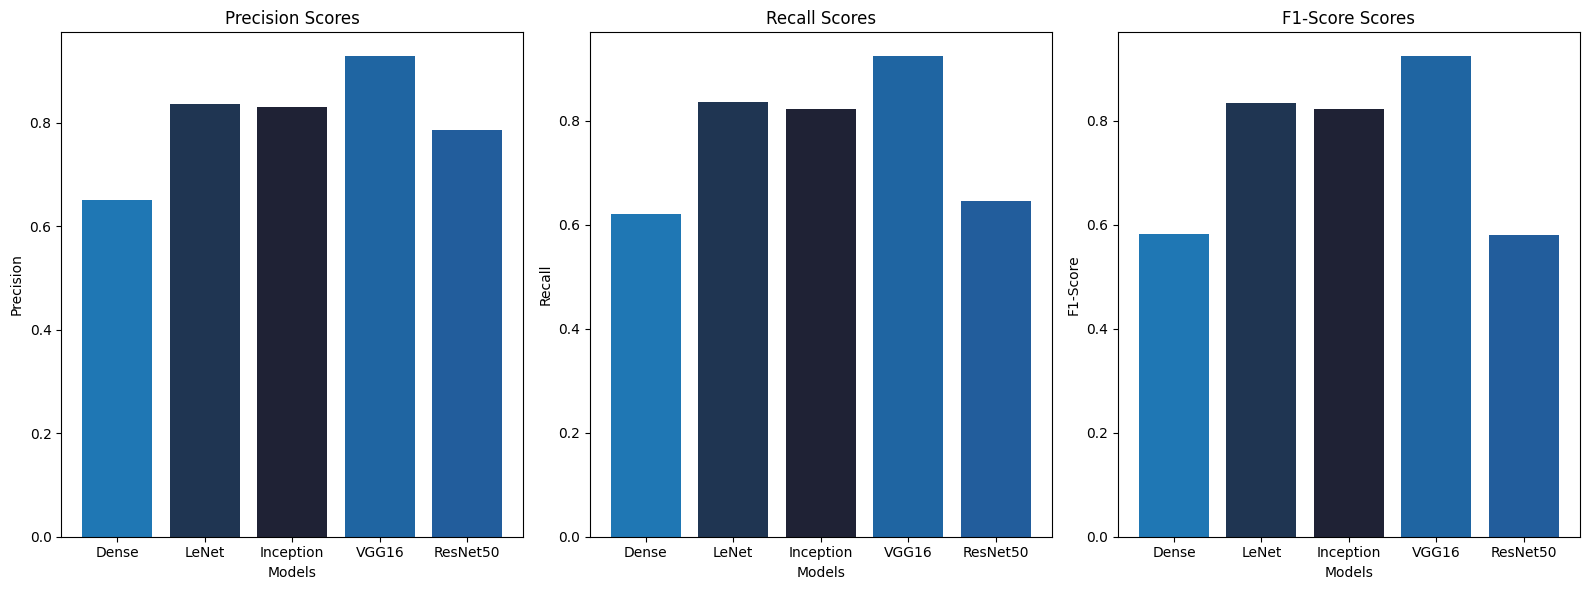

In [ ]:
import matplotlib.pyplot as plt

# Models and their corresponding Precision, Recall, and F1-score values
models = ['Dense', 'LeNet', 'Inception', 'VGG16', 'ResNet50']
precision_values = [precision_dense, precision_lenet, precision_inception, precision_vgg, precision_resnet]
recall_values = [recall_dense, recall_lenet, recall_inception, recall_vgg, recall_resnet]
f1_values = [f1_dense, f1_lenet, f1_inception, f1_vgg, f1_resnet]

# Define different shades of blue and additional colors for each model
colors = ['#1f77b4', '#1f3552', '#1f2235', '#1f65a2', '#225d9c']

# Initialize plots
plt.figure(figsize=(16, 6))

# Plot Precision scores
plt.subplot(1, 3, 1)
plt.bar(models, precision_values, color=colors)
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Scores')

# Plot Recall scores
plt.subplot(1, 3, 2)
plt.bar(models, recall_values, color=colors)
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Scores')

# Plot F1 scores
plt.subplot(1, 3, 3)
plt.bar(models, f1_values, color=colors)
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Scores')

# Tight layout to ensure no overlap
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtain the predicted probabilities for the positive class of DenseNet model
y_pred_prob_dense = dense_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of Xception model
y_pred_prob_xception = xception_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of LeNet model
y_pred_prob_lenet = lenet_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of Inception model
y_pred_prob_inception = inception_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of VGG16 model
y_pred_prob_vgg = vgg_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of ResNet50 model
y_pred_prob_resnet = resnet_model.predict(X_test)[:, 1]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


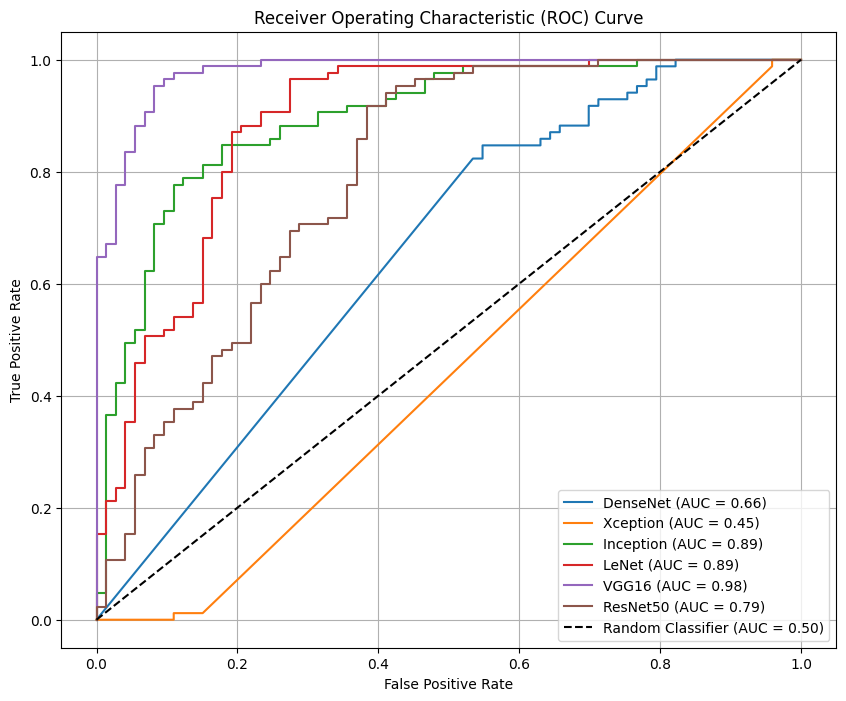

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (rest of your code) ...

# Obtain the predicted probabilities for the positive class of DenseNet model
y_pred_prob_dense = dense_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of Xception Model
y_pred_prob_xception = xception_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of LeNet model
y_pred_prob_lenet = lenet_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of Inception Model
y_pred_prob_inception = inception_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of VGG16 model
y_pred_prob_vgg = vgg_model.predict(X_test)[:, 1]

# Obtain the predicted probabilities for the positive class of ResNet50 model
y_pred_prob_resnet = resnet_model.predict(X_test)[:, 1]

# Calculate ROC curve values for each model
fpr_dense, tpr_dense, _ = roc_curve(y_true_dense, y_pred_prob_dense)
fpr_xception, tpr_xception, _ = roc_curve(y_true_xception, y_pred_prob_xception)
fpr_inception, tpr_inception, _ = roc_curve(y_true_inception, y_pred_prob_inception)
fpr_lenet, tpr_lenet, _ = roc_curve(y_true_lenet, y_pred_prob_lenet)

# Calculate ROC curve values for VGG16 and ResNet50
fpr_vgg, tpr_vgg, _ = roc_curve(y_true_vgg, y_pred_prob_vgg)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true_resnet, y_pred_prob_resnet)

# Data for all models
models = ['DenseNet', 'Xception', 'Inception', 'LeNet', 'VGG16', 'ResNet50']
fprs = [fpr_dense, fpr_xception, fpr_inception, fpr_lenet, fpr_vgg, fpr_resnet]
tprs = [tpr_dense, tpr_xception, tpr_inception, tpr_lenet, tpr_vgg, tpr_resnet]
auc_scores = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]

# Plotting ROC curves for all models
plt.figure(figsize=(10, 8))

for i, model_name in enumerate(models):
    plt.plot(fprs[i], tprs[i], label=f'{model_name} (AUC = {auc_scores[i]:.2f})')

# Plot the ROC curve for the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# Customize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


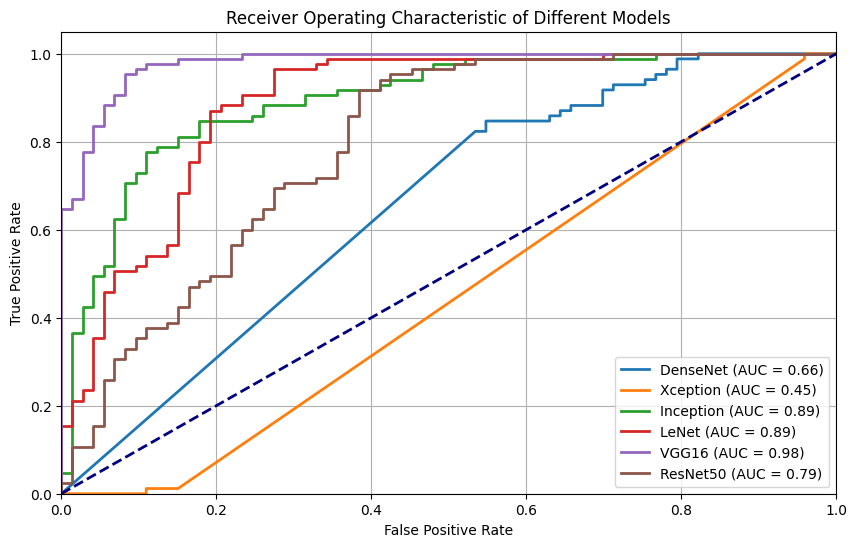

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have the predictions and true labels for the models
# Example: Obtain the predicted probabilities for the positive class of each model
y_pred_prob_dense = dense_model.predict(X_test)[:, 1]
y_pred_prob_xception = xception_model.predict(X_test)[:, 1]
y_pred_prob_lenet = lenet_model.predict(X_test)[:, 1]
y_pred_prob_inception = inception_model.predict(X_test)[:, 1]
y_pred_prob_vgg = vgg_model.predict(X_test)[:, 1]   # VGG16 model
y_pred_prob_resnet = resnet_model.predict(X_test)[:, 1]  # ResNet50 model

# Assuming y_true is the true labels for the test set
y_true_dense = np.argmax(y_test, axis=1)
y_true_xception = np.argmax(y_test, axis=1)
y_true_lenet = np.argmax(y_test, axis=1)
y_true_inception = np.argmax(y_test, axis=1)
y_true_vgg = np.argmax(y_test, axis=1)   # For VGG16 model
y_true_resnet = np.argmax(y_test, axis=1)  # For ResNet50 model

# Calculate ROC curve values for each model
fpr_dense, tpr_dense, _ = roc_curve(y_true_dense, y_pred_prob_dense)
fpr_xception, tpr_xception, _ = roc_curve(y_true_xception, y_pred_prob_xception)
fpr_inception, tpr_inception, _ = roc_curve(y_true_inception, y_pred_prob_inception)
fpr_lenet, tpr_lenet, _ = roc_curve(y_true_lenet, y_pred_prob_lenet)
fpr_vgg, tpr_vgg, _ = roc_curve(y_true_vgg, y_pred_prob_vgg)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true_resnet, y_pred_prob_resnet)

# Data for all models
models = ['DenseNet', 'Xception', 'Inception', 'LeNet', 'VGG16', 'ResNet50']
fprs = [fpr_dense, fpr_xception, fpr_inception, fpr_lenet, fpr_vgg, fpr_resnet]
tprs = [tpr_dense, tpr_xception, tpr_inception, tpr_lenet, tpr_vgg, tpr_resnet]
auc_scores = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]

# Plotting ROC curves for all models
plt.figure(figsize=(10, 6))

for model, fpr, tpr, auc_score in zip(models, fprs, tprs, auc_scores):
    plt.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {auc_score:.2f})')

# Plot the ROC curve for the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot axes and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Different Models')
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()


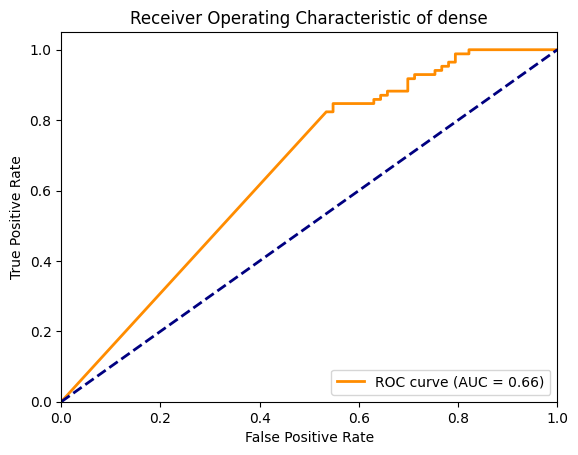

In [ ]:
# Compute the false positive rate, true positive rate, and classification threshold of dense
fpr_dense, tpr_dense, thresholds_dense = roc_curve(y_true_dense, y_pred_prob_dense)
# Compute the AUC score
roc_auc = auc(fpr_dense, tpr_dense)
# Plot the ROC curve
plt.figure()
plt.plot(fpr_dense, tpr_dense, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of dense')
plt.legend(loc="lower right")
plt.show()

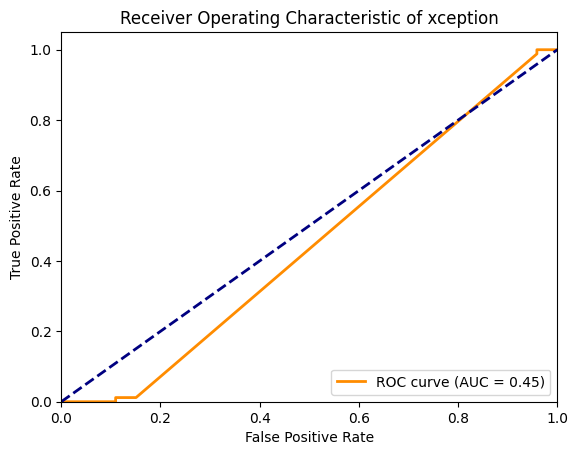

In [ ]:
# Compute the false positive rate, true positive rate, and classification threshold of xception
fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_prob_xception)
# Compute the AUC score
roc_auc = auc(fpr_xception, tpr_xception)
# Plot the ROC curve
plt.figure()
plt.plot(fpr_xception, tpr_xception, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of xception')
plt.legend(loc="lower right")
plt.show()

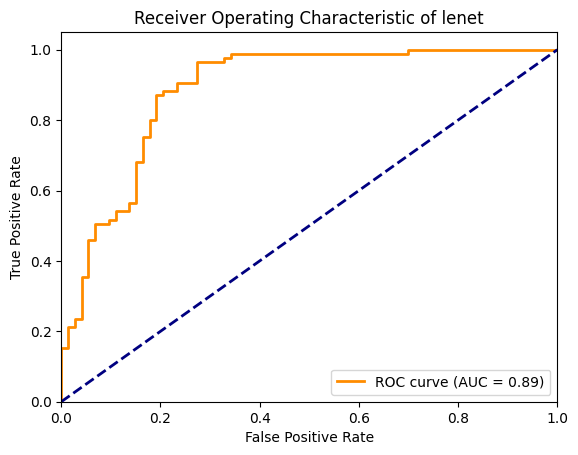

In [ ]:
# Compute the false positive rate, true positive rate, and classification threshold of xception
fpr_lenet, tpr_lenet, thresholds_lenet = roc_curve(y_true_lenet, y_pred_prob_lenet)
# Compute the AUC score
roc_auc = auc(fpr_lenet, tpr_lenet)
# Plot the ROC curve
plt.figure()
plt.plot(fpr_lenet, tpr_lenet, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of lenet')
plt.legend(loc="lower right")
plt.show()

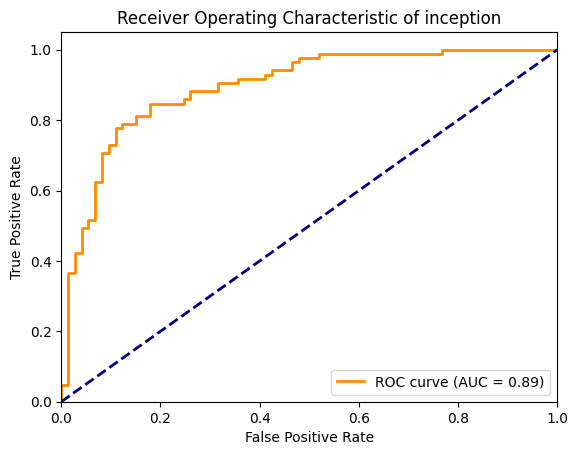

In [ ]:

# Compute the false positive rate, true positive rate, and classification threshold of xception
fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_prob_inception)
# Compute the AUC score
roc_auc = auc(fpr_inception, tpr_inception)
# Plot the ROC curve
plt.figure()
plt.plot(fpr_inception, tpr_inception, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of inception')
plt.legend(loc="lower right")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


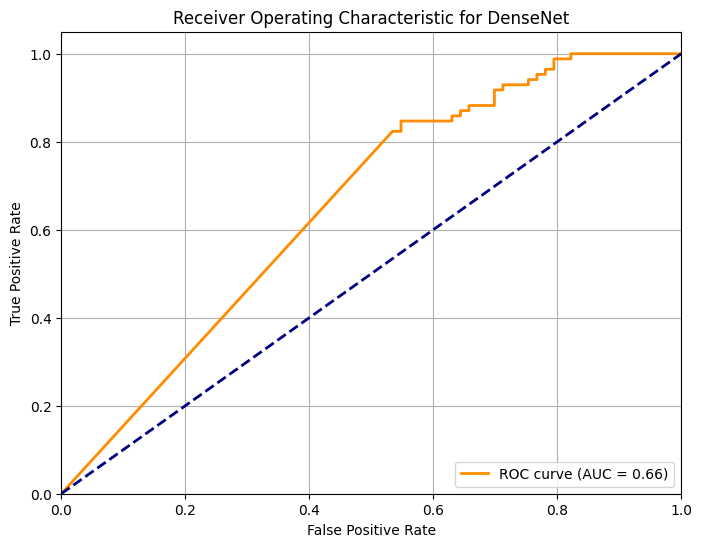

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtain the predicted probabilities for the positive class of DenseNet model
y_pred_prob_dense = dense_model.predict(X_test)[:, 1]  # Ensure you are getting the probabilities for the positive class

# Assuming y_true_dense is the true labels of the test set (one-hot encoded labels converted to class indices)
y_true_dense = np.argmax(y_test, axis=1)  # Convert one-hot encoded to class labels

# Compute the false positive rate, true positive rate, and thresholds for DenseNet
fpr_dense, tpr_dense, thresholds_dense = roc_curve(y_true_dense, y_pred_prob_dense)

# Compute the AUC score for DenseNet
roc_auc = auc(fpr_dense, tpr_dense)

# Plot the ROC curve for DenseNet
plt.figure(figsize=(8, 6))
plt.plot(fpr_dense, tpr_dense, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing a random classifier
plt.xlim([0.0, 1.0])  # X-axis: False Positive Rate
plt.ylim([0.0, 1.05])  # Y-axis: True Positive Rate
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DenseNet')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


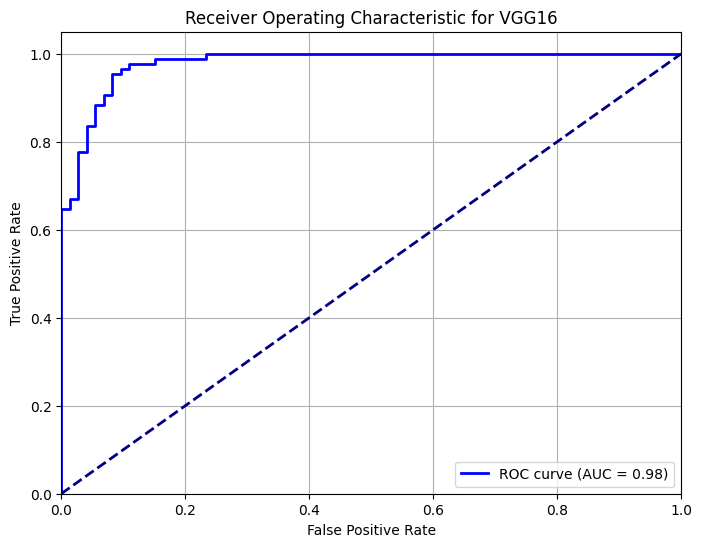

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtain the predicted probabilities for the positive class of VGG16 model
y_pred_prob_vgg16 = vgg_model.predict(X_test)[:, 1]  # Ensure you're getting the probabilities for the positive class

# Assuming y_true_vgg16 is the true labels of the test set (one-hot encoded labels converted to class indices)
y_true_vgg16 = np.argmax(y_test, axis=1)  # Convert one-hot encoded to class labels

# Compute the false positive rate, true positive rate, and thresholds for VGG16
fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_true_vgg16, y_pred_prob_vgg16)

# Compute the AUC score for VGG16
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

# Plot the ROC curve for VGG16
plt.figure(figsize=(8, 6))
plt.plot(fpr_vgg16, tpr_vgg16, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_vgg16)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing a random classifier
plt.xlim([0.0, 1.0])  # X-axis: False Positive Rate
plt.ylim([0.0, 1.05])  # Y-axis: True Positive Rate
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for VGG16')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


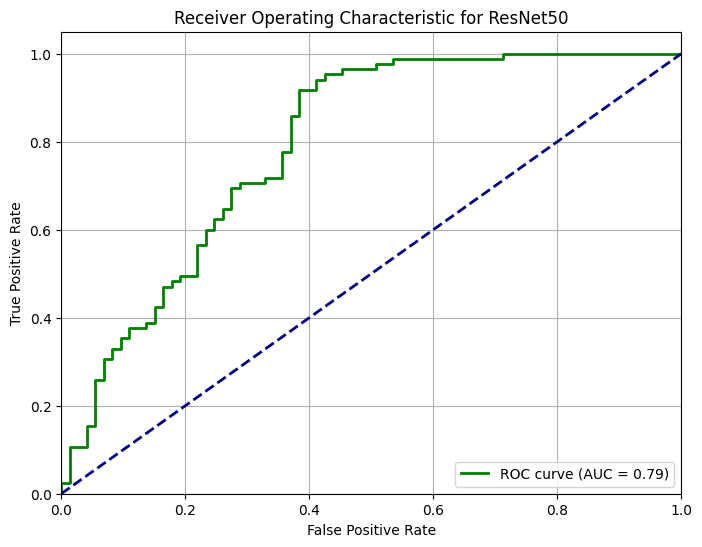

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtain the predicted probabilities for the positive class of ResNet50 model
y_pred_prob_resnet = resnet_model.predict(X_test)[:, 1]  # Assuming binary classification or class index 1

# Convert one-hot encoded true labels to class indices
y_true_resnet = np.argmax(y_test, axis=1)

# Compute FPR, TPR, and thresholds for ResNet50
fpr_resnet, tpr_resnet, thresholds_resnet = roc_curve(y_true_resnet, y_pred_prob_resnet)

# Compute AUC for ResNet50
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

# Plot ROC curve for ResNet50
plt.figure(figsize=(8, 6))
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_resnet)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for ResNet50')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Define the class labels
class_names = ['No', 'Yes']

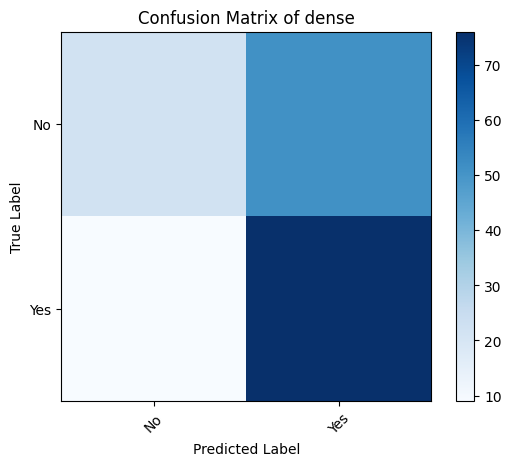

In [ ]:
# Obtain the predicted classes
y_pred_classes_dense = np.argmax(y_pred_dense, axis=1)
y_true_classes_dense = np.argmax(y_test, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes_dense, y_pred_classes_dense)
# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names)
plt.title('Confusion Matrix of dense')
plt.show()

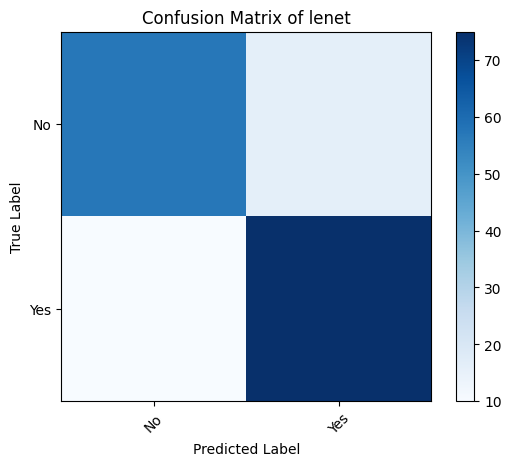

In [ ]:
# Obtain the predicted classes
y_pred_classes_lenet = np.argmax(y_pred_lenet, axis=1)
y_true_classes_lenet = np.argmax(y_test, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes_lenet, y_pred_classes_lenet)
# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names)
plt.title('Confusion Matrix of lenet')
plt.show()

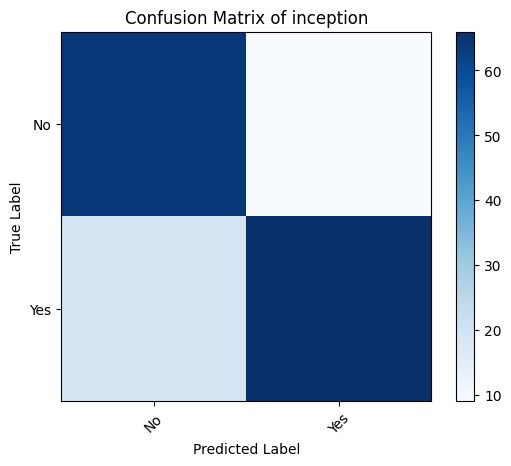

In [ ]:
# Obtain the predicted classes
y_pred_classes_inception = np.argmax(y_pred_inception, axis=1)
y_true_classes_inception = np.argmax(y_test, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes_inception, y_pred_classes_inception)
# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names)
plt.title('Confusion Matrix of inception')
plt.show()


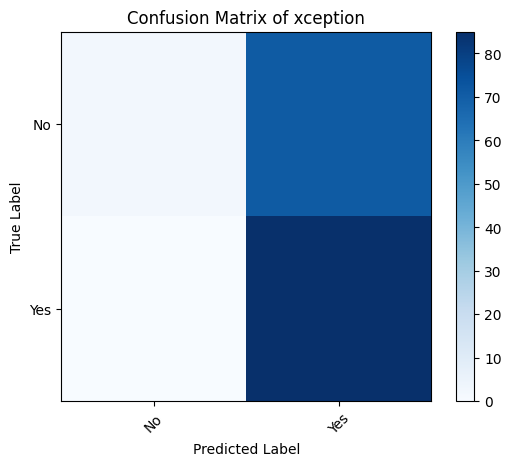

In [ ]:
# Obtain the predicted classes
y_pred_classes_xception = np.argmax(y_pred_xception, axis=1)
y_true_classes_xception = np.argmax(y_test, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes_xception, y_pred_classes_xception)
# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names)
plt.title('Confusion Matrix of xception')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


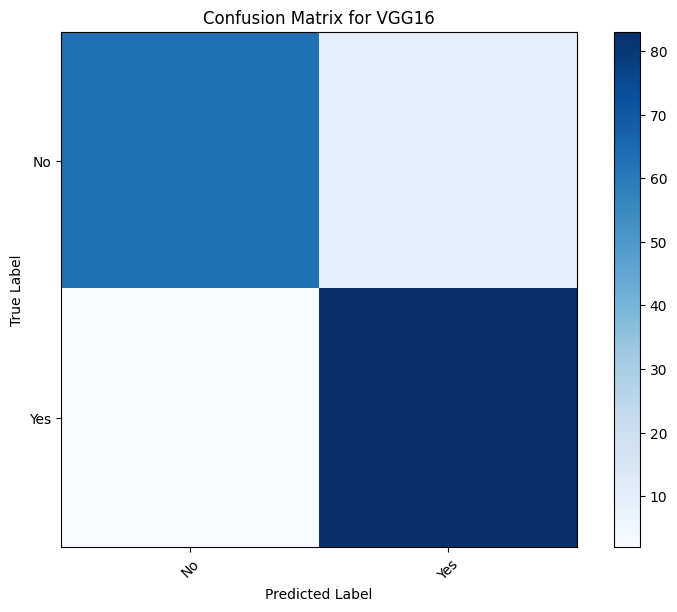

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Obtain the predicted classes for VGG16
y_pred_vgg16 = vgg_model.predict(X_test)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_vgg16 = np.argmax(y_test, axis=1)

# Compute the confusion matrix for VGG16
cm_vgg16 = confusion_matrix(y_true_vgg16, y_pred_classes_vgg16)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Plot the confusion matrix for VGG16
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_vgg16, classes=class_names)  # Ensure `class_names` is defined
plt.title('Confusion Matrix for VGG16')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


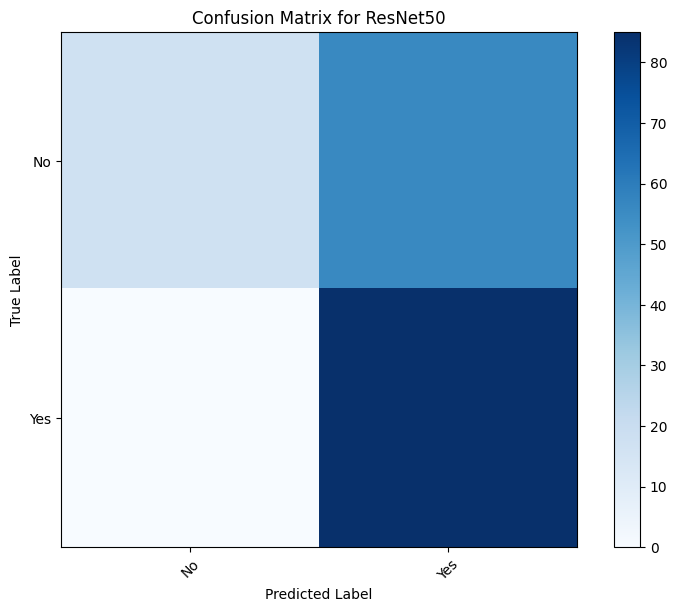

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Obtain the predicted classes for ResNet50
y_pred_resnet = resnet_model.predict(X_test)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

# Convert one-hot encoded true labels to class indices
y_true_resnet = np.argmax(y_test, axis=1)

# Compute the confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_true_resnet, y_pred_classes_resnet)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Plot the confusion matrix for ResNet50
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_resnet, classes=class_names)  # Ensure `class_names` is defined
plt.title('Confusion Matrix for ResNet50')
plt.show()


In [ ]:
cm_xception = confusion_matrix(y_true_classes_xception, y_pred_classes_xception)
cm_inception = confusion_matrix(y_true_classes_inception, y_pred_classes_inception)
cm_lenet = confusion_matrix(y_true_classes_lenet, y_pred_classes_lenet)
cm_dense = confusion_matrix(y_true_classes_dense, y_pred_classes_dense)
cm_vgg16 = confusion_matrix(y_true_vgg16,y_pred_classes_vgg16 )
cm_resnet = confusion_matrix(y_true_resnet,y_pred_classes_resnet)

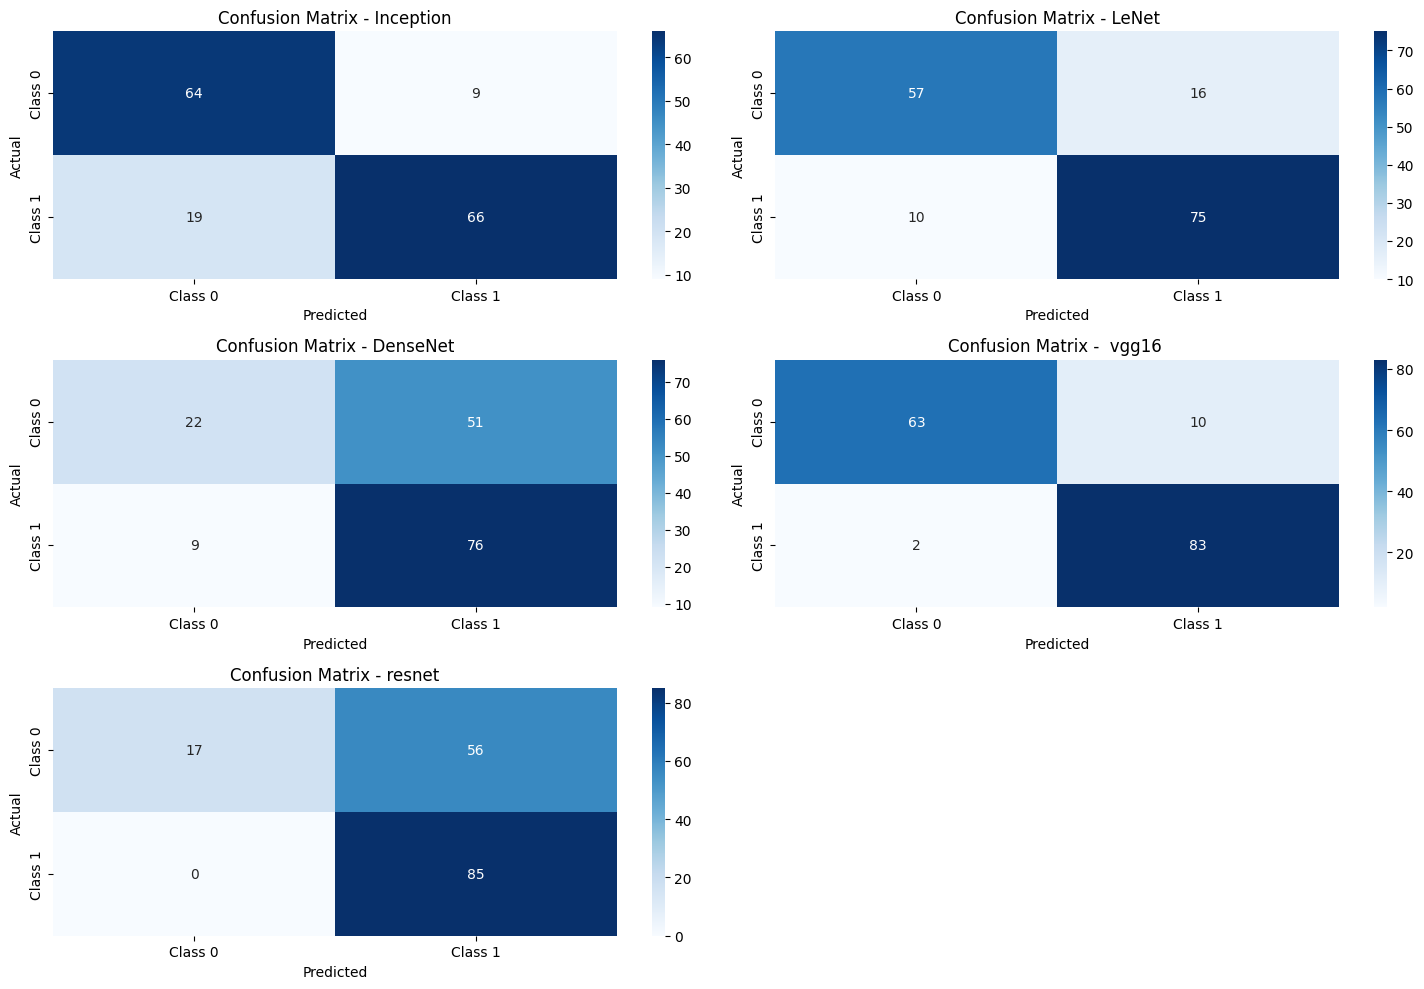

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# List of model names
model_names = ['Inception', 'LeNet', 'DenseNet',' vgg16 ',
    'resnet']

# List of confusion matrices for each model
conf_matrices = [
    cm_inception,
    cm_lenet,
    cm_dense,
    cm_vgg16,
    cm_resnet
]

# Plot confusion matrices
plt.figure(figsize=(15, 10))
for i, (model_name, conf_matrix) in enumerate(zip(model_names, conf_matrices), start=1):
    plt.subplot(3, 2, i)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()
